In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers 
import matplotlib.pyplot as plt
from IPython.display import HTML
print(tf.__version__)

2.6.0


In [2]:
# print("Available devices:", tf.config.list_physical_devices())
# print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

# Check available GPUs
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     for gpu in gpus:
#         print("Name:", gpu.name, "  Type:", gpu.device_type)
# else:
#     print("No GPU available.")

# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
    )

Found 1588 files belonging to 16 classes.


In [5]:
class_names = dataset.class_names
class_names

['Corn_Blight',
 'Corn_crop',
 'Corn_healthy',
 'Nitrogen deficiency in plant',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Rice leaf_Bacterial leaf blight',
 'Rice leaf_Brown spot',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato__Target_Spot',
 'Tomato_healthy',
 'potassium deficiency in plant',
 'potato crop']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[ 0 11  5 13  8 10  4 10 11  8 15 13  6  7  2  3  8  4 15  0  5  6  6  7
 11  8 15  7  0  5 15 13]


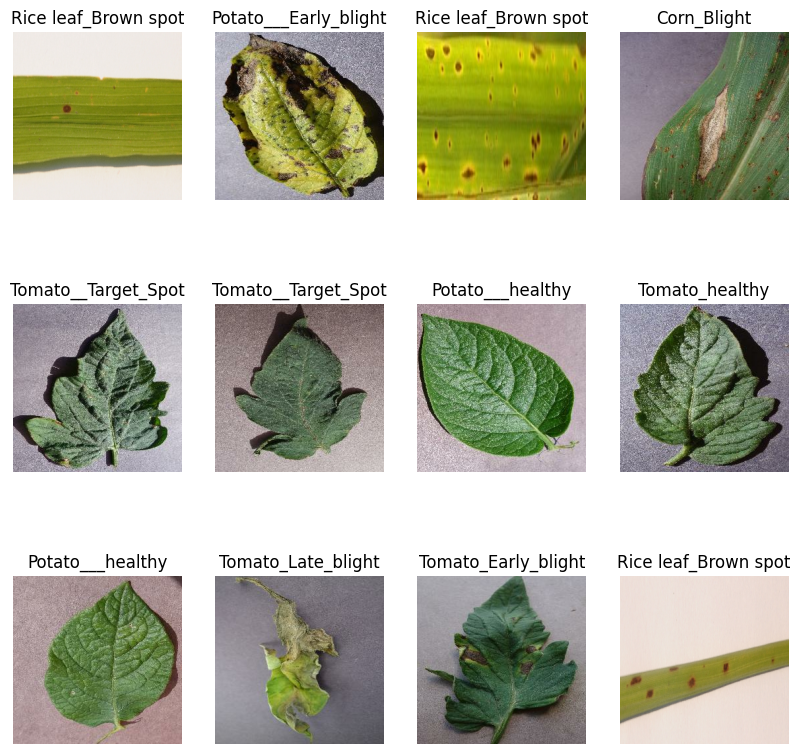

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
# Function to Split Dataset
# Dataset should be bifurcated into 3 subsets, namely:

# Training: Dataset to be used while training
# Validation: Dataset to be tested against while training
# Test: Dataset to be tested against after we trained a model

In [9]:

len(dataset)

50

In [10]:
train_size = 0.8
len(dataset)*train_size

40.0

In [11]:
train_ds = dataset.take(54)
len(train_ds)


50

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [13]:
val_size=0.1
len(dataset)*val_size

5.0

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

0

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [17]:
len(train_ds)

40

In [18]:
len(val_ds)


5

In [19]:
len(test_ds)

5

In [20]:
# Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
# Building the Model
# Creating a Layer for Resizing and Normalization
# Before we feed our images to network, we should be resizing it to the desired size. 
# Moreover, to improve model performance, we should normalize the image pixel value 
# (keeping them in range 0 and 1 by dividing by 256). 
# This should happen while training as well as inference. 
# Hence we can add that as a layer in our Sequential Model.

# You might be thinking why do we need to resize (256,256) image to again (256,256). 
# You are right we don't need to but this will be useful when we are done with the training 
# and start using the model for predictions. 
# At that time somone can supply an image that is not (256,256) and this layer will resize it

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [23]:
# Data Augmentation
# Data Augmentation is needed when we have less data, 
# this boosts the accuracy of our model by augmenting the data

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
# Applying Data Augmentation to Train Dataset

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
# Model Architecture
# We use a CNN coupled with a Softmax activation in the output layer. 
# We also add the initial layers for resizing, normalization and Data Augmentation.

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 16

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [26]:
# Compiling the Model
# We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=2,
)

Epoch 1/2
